<a href="https://colab.research.google.com/github/Chandan0731/bioinformatics_lab/blob/main/Experiment_6_Restriction_Mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install biopython matplotlib

In [4]:
from Bio import Entrez
import re

# 1. Setup Identity
Entrez.email = "chandanksshetty@gmail.com"

# 2. AUTOMATED SEARCH
print("Searching NCBI for Cytochrome Oxidase (COX1) Accession ID...")
search_term = "Homo sapiens[Organism] AND COX1[Gene] AND RefSeq"
handle = Entrez.esearch(db="nucleotide", term=search_term, retmax=1, sort="relevance")
record = Entrez.read(handle)
handle.close()

# 3. Download and Analyze
if len(record["IdList"]) > 0:
    target_id = record["IdList"][0]
    print(f"✅ Found Accession ID: {target_id}")

    print(f"Downloading sequence...")
    try:
        net_handle = Entrez.efetch(db="nucleotide", id=target_id, rettype="fasta", retmode="text")
        seq_data = net_handle.read()
        net_handle.close()

        # Clean sequence
        seq_parts = seq_data.split('\n')
        sequence_str = "".join(seq_parts[1:])
        print(f"✅ Sequence Loaded Successfully: {len(sequence_str)} base pairs.")

        # --- PERFORM ANALYSIS ---
        def find_cuts(seq, pattern):
            # Find all matches, but strictly slice the list to the first 25
            all_cuts = [m.start() + 1 for m in re.finditer(pattern, seq)]
            return all_cuts[:25]

        enzymes = {
            'HindIII': 'AAGCTT',
            'EcoRI':   'GAATTC',
            'KpnI':    'GGTACC',
            'BamHI':   'GGATCC',
            'XhoI':    'CTCGAG'
        }

        # Store results for Block 2
        map_data = {}
        print("\n--- Analysis Results (Restricted to first 25 cuts) ---")
        for name, pattern in enzymes.items():
            cuts = find_cuts(sequence_str, pattern)
            map_data[name] = cuts

            if cuts:
                print(f"✂️ {name}: {len(cuts)} cut(s) found. Positions: {cuts}")
            else:
                print(f"• {name} does not cut.")

        print("\n✅ Data ready for plotting. Run Block 2.")

    except Exception as e:
        print(f"❌ Error fetching sequence: {e}")
        sequence_str = ""
else:
    print("❌ Auto-search failed to find an ID.")
    sequence_str = ""

Searching NCBI for Cytochrome Oxidase (COX1) Accession ID...
✅ Found Accession ID: 2194973615
✅ Sequence Loaded Successfully: 150617247 base pairs.

--- Analysis Results (Restricted to first 25 cuts) ---
✂️ HindIII: 25 cut(s) found. Positions: [9922, 18485, 21895, 24345, 26071, 26692, 31670, 32287, 32709, 33173, 43813, 47524, 47702, 51558, 54341, 56562, 58027, 59826, 62117, 71597, 78297, 80258, 81451, 85371, 93835]
✂️ EcoRI: 25 cut(s) found. Positions: [21888, 23805, 26130, 30859, 42680, 47272, 60544, 66060, 73311, 75050, 75883, 88284, 91809, 94210, 97749, 106736, 113445, 115487, 116953, 120435, 121738, 122021, 122782, 129109, 137429]
✂️ KpnI: 25 cut(s) found. Positions: [4053, 31173, 39789, 52486, 59599, 68615, 87121, 93264, 117763, 120406, 121821, 134076, 135896, 137458, 138663, 154581, 178720, 180297, 184329, 206740, 215078, 218071, 225303, 226501, 229981]
✂️ BamHI: 25 cut(s) found. Positions: [7479, 11867, 17528, 26107, 32263, 49943, 50373, 55945, 65019, 66601, 71685, 76165, 77372,

Generating Modern Static Map...


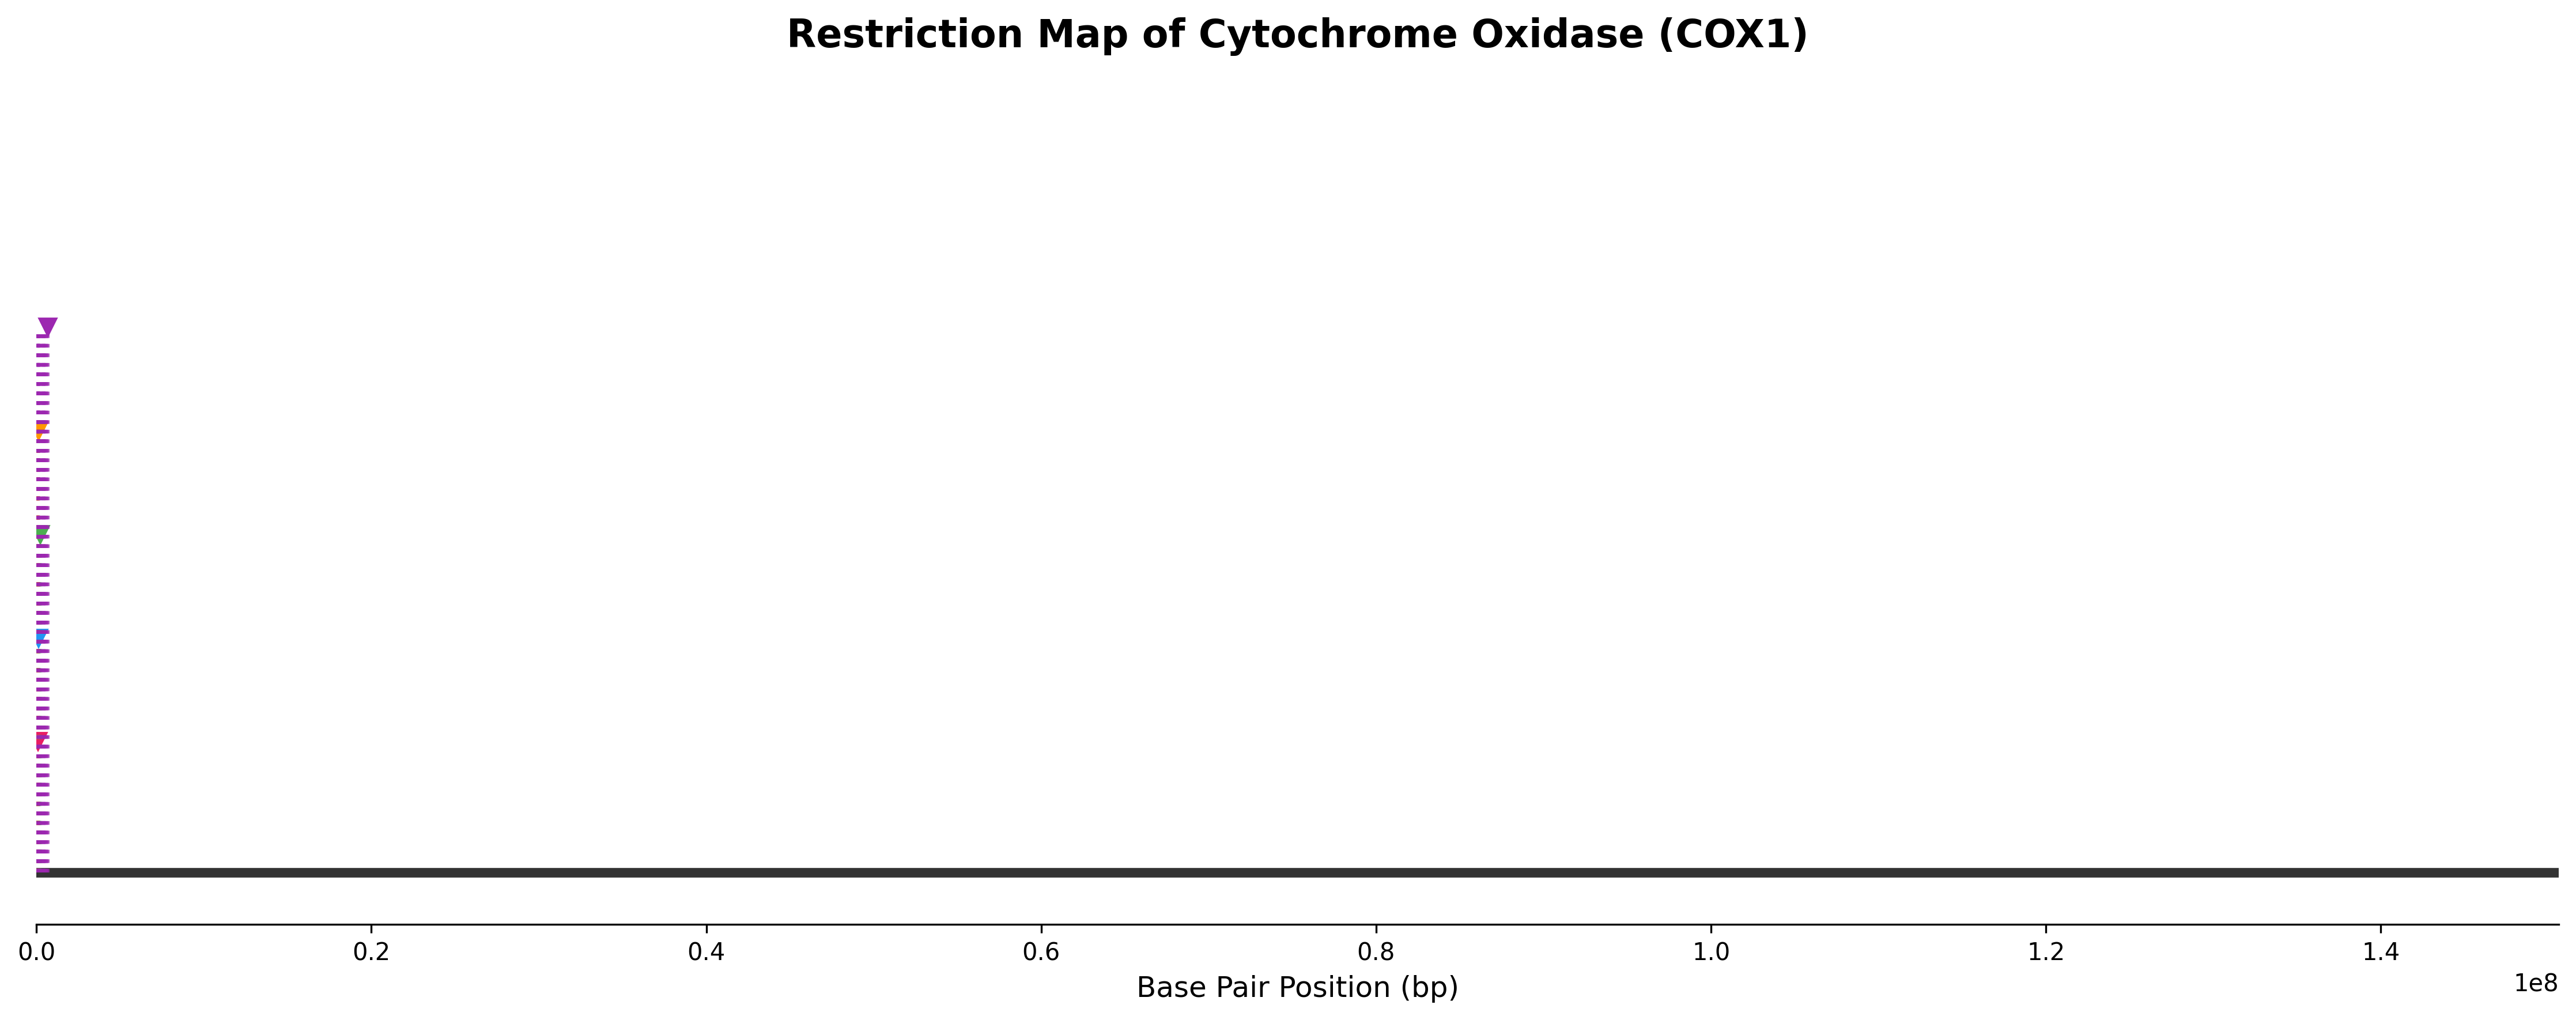

In [12]:

import matplotlib.pyplot as plt

def plot_modern_static_map(sequence_length, enzymes_data):
    # Set a nice wide figure size
    fig, ax = plt.subplots(figsize=(15, 6), dpi=300)

    # 1. Draw the DNA Backbone
    ax.plot([0, sequence_length], [0, 0], color='#333333', linewidth=4, label='DNA Sequence')

    # 2. Draw Enzymes in "Lanes"
    colors = ['#E91E63', '#2196F3', '#4CAF50', '#FF9800', '#9C27B0'] # Material Design Colors

    for i, (enzyme_name, cut_sites) in enumerate(enzymes_data.items()):
        if not cut_sites:
            continue

        color = colors[i % len(colors)]

        # Create a "Lane" height for this enzyme (0.3, 0.6, 0.9, etc.)
        lane_height = 0.5 + (i * 0.4)

        # A. Draw the Marker (The coloured bar at the top)
        ax.plot(cut_sites, [lane_height] * len(cut_sites), 'v',
                color=color, markersize=10, markeredgecolor='white')

        # B. Draw the "Drop Line" (Dotted line down to DNA)
        ax.vlines(cut_sites, 0, lane_height, color=color, linestyles='dotted', alpha=0.6)

        # C. Add Labels
        for site in cut_sites:
            # Only label if not too crowded
            if len(cut_sites) < 15:
                ax.text(site, lane_height + 0.1, f"{enzyme_name}\n{site}",
                        ha='center', va='bottom', fontsize=9, fontweight='bold', color=color)

    # 3. Beautify the Graph
    ax.set_title("Restriction Map of Cytochrome Oxidase (COX1)", fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel("Base Pair Position (bp)", fontsize=12)
    ax.set_xlim(0, sequence_length)
    ax.set_ylim(-0.2, 3.0) # Enough height for all lanes

    # Clean style (Hide Y axis and box borders)
    ax.get_yaxis().set_visible(False)
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()

# Run the plotter
if 'sequence_str' in locals() and len(sequence_str) > 0:
    print("Generating Modern Static Map...")
    plot_modern_static_map(len(sequence_str), map_data)
else:
    print("❌ No sequence data found. Please run Block 1 first.")